In [27]:
import sklearn
import pandas as pd 
import numpy as np
import scipy
import itertools
import readline
import matplotlib
import matplotlib.pyplot as plt
from ipython_helpers import (
    print_full
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    fbeta_score,
    make_scorer,
    recall_score,
    precision_score,
    r2_score,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
%matplotlib inline  

In [10]:
def make_input_df(df):
    X = pd.DataFrame()
    X['CASHMTA'] = df['CASHMTA_win']
    X['EXRET_AVG'] = df['EXRET_AVG_win']
    X['MB'] = df['MB_win']
    X['NIMTA_AVG'] = df['NIMTA_AVG_win']
    X['PRICE'] = df['PRICE_win']
    X['RSIZE'] = df['RSIZE_win']
    X['SIGMA'] = df['SIGMA_win']
    X['TLMTA'] = df['TLMTA_win']
    
    return X

def make_output_df(df):
    y = pd.DataFrame()
    y['is_bankrupt'] = df['is_bankrupt_within_24']
    
    return y


def make_train_and_test_df(train_df, test_df):
    X_train = make_input_df(train_df)
    X_test = make_input_df(test_df)
    y_train = make_output_df(train_df)
    y_test = make_output_df(test_df)
    
    return X_train, X_test, y_train, y_test


def make_base_rate_model(X):
    y = np.zeros(X.shape[0], dtype=bool)

    return y


def make_time_series_iterable(df, start_year):
    end_year = df['year'].max() + 1
    input_df = make_input_df(df)

    iterator = []
    for year in range(start_year, end_year):
        train_index = df[df['year'] < year].index.values.astype(int)
        test_index = df[df['year'] == year].index.values.astype(int)
        iterator.append((train_index, test_index))
        
    return iterator


def plot_roc_curve(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, thresholds


def plot_confusion_matrix(test_output, predicted_output, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(test_output, predicted_output)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
def display_all_results(x_test, y_test, estimator, probability=False):
    y_pred_bin = estimator.predict(x_test)
    print("F1 Score")
    print(f1_score(y_test, y_pred_bin))
    
    print("Recall Score")
    print(recall_score(y_test, y_pred_bin))
    
    print("Precision Score")
    print(precision_score(y_test, y_pred_bin))

    print("Detailed classification report:")

    print(classification_report(y_test, y_pred_bin))
    print()

    print("Confusion Matrix:")
    plot_confusion_matrix(y_test, y_pred_bin, ['Active', 'Bankrupt'])
    print()

    if probability:
        print("Roc Curve:")
        y_pred_prob = estimator.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test, y_pred_prob)
        print()
        

def train_model_by_random_search_cv(X_train, X_test, y_train, y_test, estimator, tuned_parameters, custom_iterable, scores=None, probability=False):

    if scores is None:
        scores = ['roc_auc', 'precision']
    
    for score in scores:
        print("Tuning hyper-parameters for %s" % score)
        print()

        clf = RandomizedSearchCV(estimator, tuned_parameters, cv=custom_iterable, scoring=score, verbose=1, n_iter=20, n_jobs=-1)
        clf.fit(X_train, y_train.values.ravel())

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        
        display_all_results(X_test, y_test, clf, probability)

    return clf


def train_model_by_grid_search_cv(X_train, X_test, y_train, y_test, estimator, tuned_parameters, custom_iterable, scores=None, probability=False):

    if scores is None:
        scores = ['roc_auc', 'precision']
    
    for score in scores:
        print("Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(estimator, tuned_parameters, cv=custom_iterable, scoring=score, verbose=1, n_jobs=-1)
        clf.fit(X_train, y_train.values.ravel())

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        
        display_all_results(X_test, y_test, clf, probability)
        
    return clf 

            

# Read Data

In [3]:
train_df = pd.read_csv("../../../../Development/econ985/campbell_data/train_df_annual_24.csv")
test_df = pd.read_csv("../../../../Development/econ985/campbell_data/test_df_annual_24.csv")

In [6]:
X_train, X_test, y_train, y_test = make_train_and_test_df(train_df, test_df)

# Train Models

### 1) Dummy Classifier (Always Predicts False for Bankruptcy)

F1 Score
0.0
Recall Score
0.0
Precision Score
0.0
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      1.00      1.00     35471
       True       0.00      0.00      0.00        74

avg / total       1.00      1.00      1.00     35545

()
Confusion Matrix:


/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wentaoxu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[35471     0]
 [   74     0]]


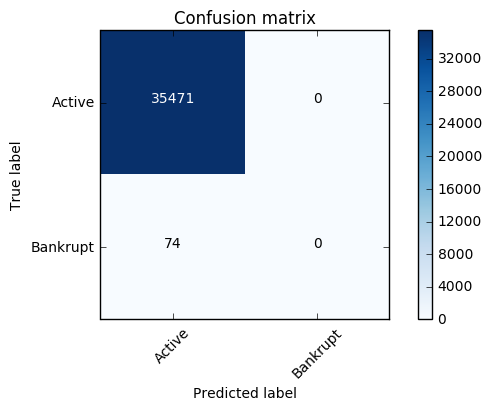

()


In [7]:
estimator_dummy = DummyClassifier(strategy='most_frequent', constant=False)
estimator_dummy.fit(X_train, y_train.values.ravel())
display_all_results(X_test, y_test, estimator_dummy)

### 2) Logistic Regression

In [8]:
estimator_lr = LogisticRegression()
tuned_parameters_lr = {
    'penalty': ['l1', 'l2'],
    'C': scipy.stats.expon(scale=100),
    'class_weight' :['balanced', {True: 1000}, {True: 3000}] 
}
ts_iterable = make_time_series_iterable(train_df, 1995)
scores_lr = ['f1']

Tuning hyper-parameters for f1
()
Fitting 11 folds for each of 20 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed: 11.2min finished


Best parameters set found on development set:
()
{'penalty': 'l2', 'C': 8.3857506405752549, 'class_weight': 'balanced'}
()
F1 Score
0.0232795589136
Recall Score
0.77027027027
Precision Score
0.0118183703089
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.87      0.93     35471
       True       0.01      0.77      0.02        74

avg / total       1.00      0.87      0.93     35545

()
Confusion Matrix:
Confusion matrix, without normalization
[[30705  4766]
 [   17    57]]


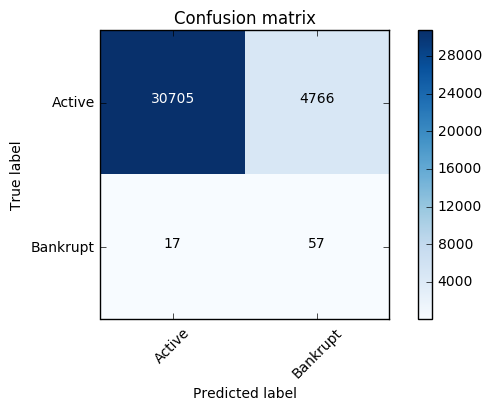

()
Roc Curve:


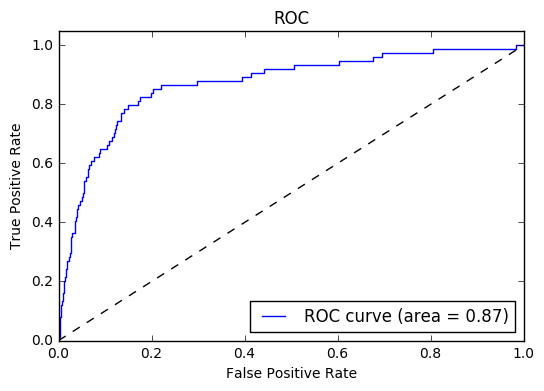

()


In [11]:
trained_estimator_lr = train_model_by_random_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_lr, 
    tuned_parameters_lr, 
    ts_iterable, 
    scores_lr,
    probability=True
)

### 3) Decision Tree

##### Decision Tree - Objective=f1

Tuning hyper-parameters for f1
()
Fitting 11 folds for each of 54 candidates, totalling 594 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed:  7.1min finished


Best parameters set found on development set:
()
{'min_samples_leaf': 5, 'criterion': 'gini', 'max_depth': None, 'class_weight': {True: 1000}}
()
F1 Score
0.0246153846154
Recall Score
0.0540540540541
Precision Score
0.0159362549801
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.99      1.00     35471
       True       0.02      0.05      0.02        74

avg / total       1.00      0.99      0.99     35545

()
Confusion Matrix:
Confusion matrix, without normalization
[[35224   247]
 [   70     4]]


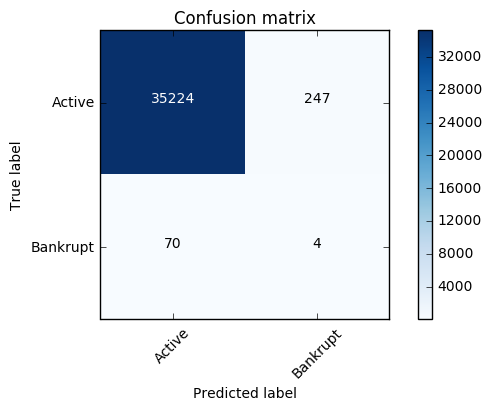

()


In [25]:
estimator_dt = DecisionTreeClassifier()
tuned_parameters = {
    'class_weight': ['balanced', {True: 1000}, {True: 3000}],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['f1']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=f2

Tuning hyper-parameters for make_scorer(fbeta_score, beta=2, pos_label=True, average=binary)
()
Fitting 11 folds for each of 72 candidates, totalling 792 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 792 out of 792 | elapsed:  7.1min finished


Best parameters set found on development set:
()
{'min_samples_leaf': 5, 'criterion': 'entropy', 'max_depth': None, 'class_weight': {True: 1000}}
()
F1 Score
0.0112676056338
Recall Score
0.027027027027
Precision Score
0.00711743772242
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.99      1.00     35471
       True       0.01      0.03      0.01        74

avg / total       1.00      0.99      0.99     35545

()
Confusion Matrix:
Confusion matrix, without normalization
[[35192   279]
 [   72     2]]


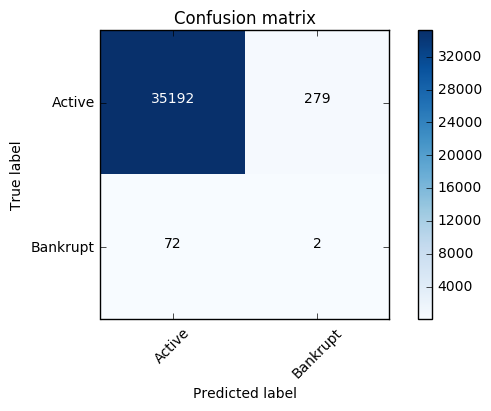

()


In [28]:
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=True, average='binary')
scores = [f2_scorer]
tuned_parameters = {
    'class_weight': ['balanced', {True: 1000}, {True: 2000}, {True: 3000}],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = balanced (~490)

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1.6min finished


Best parameters set found on development set:
()
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.0213344488601
Recall Score
0.689189189189
Precision Score
0.0108349267049
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.87      0.93     35471
       True       0.01      0.69      0.02        74

avg / total       1.00      0.87      0.93     35545

()
Confusion Matrix:
Confusion matrix, without normalization
[[30815  4656]
 [   23    51]]


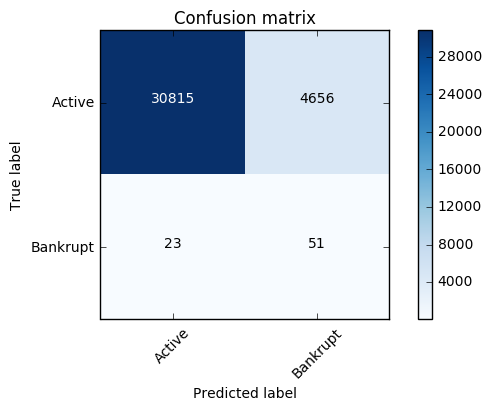

()


In [12]:
estimator_dt = DecisionTreeClassifier(class_weight='balanced')
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = 1000

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1.7min finished


Best parameters set found on development set:
()
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.00886393854336
Recall Score
0.810810810811
Precision Score
0.00445632798574
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.62      0.77     35471
       True       0.00      0.81      0.01        74

avg / total       1.00      0.62      0.77     35545

()
Confusion Matrix:
Confusion matrix, without normalization
[[22067 13404]
 [   14    60]]


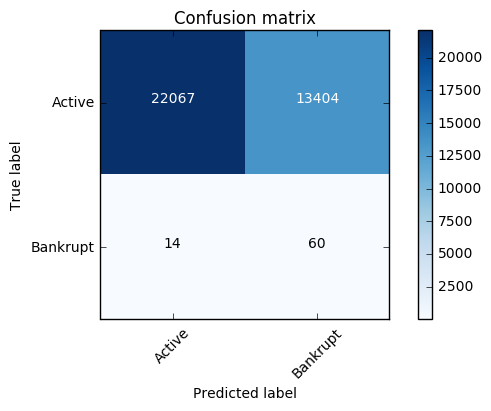

()


In [13]:
estimator_dt = DecisionTreeClassifier(class_weight={True:1000})
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = 2000

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1.6min finished


Best parameters set found on development set:
()
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.00493476391641
Recall Score
0.891891891892
Precision Score
0.00247422680412
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.25      0.40     35471
       True       0.00      0.89      0.00        74

avg / total       1.00      0.25      0.40     35545

()
Confusion Matrix:
Confusion matrix, without normalization
[[ 8862 26609]
 [    8    66]]


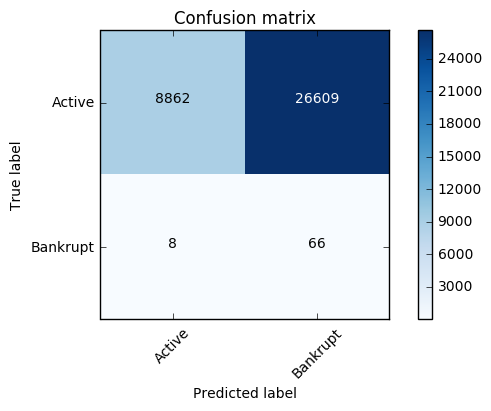

()


In [18]:
estimator_dt = DecisionTreeClassifier(class_weight={True:2000})
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

##### Decision Tree - Objective=recall, Class Weight = 3000

Tuning hyper-parameters for recall
()
Fitting 11 folds for each of 18 candidates, totalling 198 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1.8min finished


Best parameters set found on development set:
()
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
()
F1 Score
0.00499300223172
Recall Score
0.891891891892
Precision Score
0.00250350870538
Detailed classification report:
             precision    recall  f1-score   support

      False       1.00      0.26      0.41     35471
       True       0.00      0.89      0.00        74

avg / total       1.00      0.26      0.41     35545

()
Confusion Matrix:
Confusion matrix, without normalization
[[ 9174 26297]
 [    8    66]]


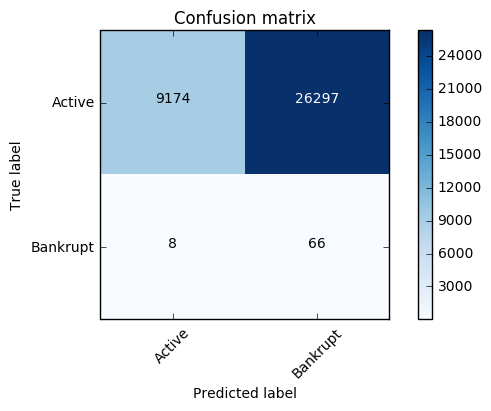

()


In [20]:
estimator_dt = DecisionTreeClassifier(class_weight={True:3000})
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
scores = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_dt, 
    tuned_parameters,
    ts_iterable,
    scores
)

In [ ]:
estimator_rf = RandomForestClassifier(class_weight="balanced", verbose=1)
tuned_parameters_rf = {
    'n_estimators': [10, 100, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False],
}
scores_rf = ['recall', 'roc_auc']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_rf, 
    tuned_parameters_rf,
    ts_iterable,
    scores_rf
)

In [ ]:
estimator_svm_svc = svm.SVC(class_weight="balanced")
estimator_svm_svc.fit(X_train, y_train.values.ravel())

In [ ]:
display_all_results(X_test, y_test, estimator_svm_svc)

In [ ]:
estimator_svm_svc = svm.SVC(class_weight="balanced", verbose=1)
tuned_parameters_svm_svc = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
}
scores_svm_svc = ['recall']
trained_estimator_df = train_model_by_grid_search_cv(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    estimator_svm_svc, 
    tuned_parameters_svm_svc,
    ts_iterable,
    scores_svm_svc
)